In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
# import xgboost

import sklearn.metrics as metrics

import seaborn as sns

import math as m

from sklearn.preprocessing import LabelEncoder, StandardScaler

# from imblearn.over_sampling import SMOTE

import warnings

warnings.filterwarnings('ignore')

import random

from sklearn.cross_validation import KFold

%matplotlib inline

from matplotlib.colors import ListedColormap

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

from pylab import rcParams

rcParams['figure.figsize'] = 8,6

from sklearn.model_selection import GroupKFold

# import ak.utility as util

from sklearn.linear_model import LogisticRegression

from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.svm import SVC

from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
import datetime

tqdm_notebook().pandas()

HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

In [20]:
df = pd.read_csv('/Users/aakashkerawat/NotebookProjects/AV_click/train.csv')
df_t = pd.read_csv('/Users/aakashkerawat/NotebookProjects/AV_click/test.csv')
df_cam = pd.read_csv('/Users/aakashkerawat/NotebookProjects/AV_click/campaign_data.csv')
df_sub = pd.read_csv('/Users/aakashkerawat/NotebookProjects/AV_click/sample_submission_4fcZwvQ.csv')

In [21]:
df = df.merge(df_cam, 'left', 'campaign_id')

df_t = df_t.merge(df_cam, 'left', 'campaign_id')

In [22]:
def parse_date(df_temp, date_col):
    df_temp[date_col] = pd.to_datetime(df_temp[date_col], format='%d-%m-%Y %H:%M')
    df_temp[date_col+'_dow'] = df_temp[date_col].dt.weekday
    df_temp[date_col+'_dom'] = df_temp[date_col].dt.day
    df_temp[date_col+'tod'] = df_temp[date_col].dt.hour
    return df_temp

In [23]:
def other_text_feats(df_temp, all_cols):
    for col in all_cols:
        df_temp['len_'+col] = df_temp[col].apply(lambda x: len(x.split()))
    return df_temp

In [24]:
def get_email_number(df_temp):
    df_temp['email_number'] = range(1, len(df_temp)+1)
    return df_temp

In [25]:
def get_date_diff(df_temp):
    df_temp['days_since_first_email'] = (df_temp['send_date']-df_temp['send_date'].min()).dt.days
    df_temp['days_since_last_email'] = df_temp['days_since_first_email']-df_temp['days_since_first_email'].shift()
    return df_temp

In [26]:
def add_expanding_mean(df_temp, col):
    df_temp = df_temp.sort_values('send_date')
    df_temp[col+'_mean'] = df_temp[col].shift().expanding().mean()
#     df_temp[col+'_sum'] = df_temp[col].shift().expanding().sum()
    return df_temp

In [27]:
def get_user_full_feature(df_tr_, df_t_):
    df_full = pd.concat([df_tr_, df_t_]).reset_index(drop=True)
    print 'adding date diff feature' 
    user_reg = df_full[['id', 'user_id', 'send_date']].groupby('user_id').progress_apply(get_date_diff)
    df_tr_ = df_tr_.merge(user_reg[['id', 'days_since_first_email','days_since_last_email']], 'left', 'id')
    df_t_ = df_t_.merge(user_reg[['id', 'days_since_first_email', 'days_since_last_email']], 'left', 'id')
    
    user_comm_count = df_full.groupby(['user_id', 'communication_type']).size().unstack(1).reset_index()
    user_comm_count.columns = [col+'_count' if col!='user_id' else col for col in user_comm_count.columns]

    user_comm_count.fillna(0, inplace=True)
    df_tr_ = df_tr_.merge(user_comm_count, 'left', 'user_id')
    df_t_ = df_t_.merge(user_comm_count, 'left', 'user_id')
    
    print 'Adding email number feature'
    df_sub = df_full[['id', 'user_id', 'send_date']].sort_values(['user_id', 'send_date']).reset_index(drop=True)
    email_num = df_sub.groupby(['user_id']).progress_apply(get_email_number)
    
    df_tr_ = df_tr_.merge(email_num[['id', 'email_number']], 'left', 'id')
    df_t_ = df_t_.merge(email_num[['id', 'email_number']], 'left', 'id')
    return df_tr_, df_t_

In [28]:
def get_user_tr_feature(df_tr_, df_t_):  
    print 'Adding click mean feature in rolling fashion'
    is_click_mean = df_tr_[['id', 'user_id', 'send_date', 'is_click']].groupby('user_id').progress_apply(lambda x: add_expanding_mean(x, 'is_click'))
    df_tr_ = df_tr_.merge(is_click_mean[['id', 'is_click_mean']], 'left', ['id'])
    is_click_mean_all = df_tr_.groupby('user_id')['is_click'].mean().reset_index().rename(columns={'is_click':'is_click_mean'})
    df_t_ = df_t_.merge(is_click_mean_all, 'left', ['user_id'])


    print 'Adding open mean feature in rolling fashion'
    is_open_mean = df_tr_[['id', 'user_id', 'send_date', 'is_open']].groupby('user_id').progress_apply(lambda x: add_expanding_mean(x, 'is_open'))
    df_tr_ = df_tr_.merge(is_open_mean[['id', 'is_open_mean']], 'left', ['id'])
    is_open_mean_all = df_tr_.groupby('user_id')['is_open'].mean().reset_index().rename(columns={'is_open':'is_open_mean'})
    df_t_ = df_t_.merge(is_open_mean_all, 'left', ['user_id'])    
    return df_tr_, df_t_

In [29]:
def get_subject_info(value):
    out = re.findall('\[\w*\s*\w*]', value)
    if len(out):
        return out[0].replace('[', '').replace(']', '')
    else: return np.nan

In [30]:
def get_last_click_date(df_temp, target):
    df_temp['last_'+target+'_date'] = df_temp.loc[df_temp[target].fillna(0).astype(bool), 'send_date']
    df_temp['last_'+target+'_date'] = df_temp['last_'+target+'_date'].shift().ffill()
    return df_temp

In [31]:
df = parse_date(df, 'send_date')

df_t = parse_date(df_t, 'send_date')

In [32]:
df_all = pd.concat([df, df_t]).sort_values(['user_id', 'send_date']).reset_index(drop=True)

In [36]:
df_all = df_all.groupby('user_id').progress_apply(get_last_click_date, 'is_open')

HBox(children=(IntProgress(value=0, max=220719), HTML(value=u'')))

In [37]:
ew_mean = df_all.groupby('user_id')['is_click'].progress_apply(lambda x: x.shift().ewm(alpha=0.77).mean())

df_all['is_click_ewm'] = ew_mean

HBox(children=(IntProgress(value=0, max=220719), HTML(value=u'')))

In [38]:
# ew_mean = df_all.groupby('user_id')['is_open'].progress_apply(lambda x: x.shift().ewm(alpha=0.77).mean())

# df_all['is_open_ewm'] = ew_mean

In [39]:
# ew_mean = df_all.groupby('user_id')['is_click'].progress_apply(lambda x: x.shift().ewm(alpha=0.4).mean())

# df_all['is_click_ewm_2'] = ew_mean

In [40]:
# window_2_mean = df_all.groupby('user_id')['is_click'].progress_apply(lambda x: x.shift().rolling(window=2).mean().ffill())

# df_all['is_click_w2_mean'] = window_2_mean

In [41]:
df = df_all.loc[df_all['id'].isin(df['id'].unique())].reset_index(drop=True)

In [42]:
df_t = df_all.loc[df_all['id'].isin(df_t['id'].unique())].reset_index(drop=True)

In [43]:
# df['last_click_before_days'] = (df['send_date'] - df['last_click_date']).dt.days

# df_t['last_click_before_days'] = (df_t['send_date'] - df_t['last_click_date']).dt.days

In [44]:
df['last_is_open_before_days'] = (df['send_date'] - df['last_is_open_date']).dt.days

In [45]:
df_t['last_is_open_before_days'] = (df_t['send_date'] - df_t['last_is_open_date']).dt.days

In [46]:
del df_all

In [47]:
df = other_text_feats(df, ['subject', 'email_body'])
df_t = other_text_feats(df_t, ['subject', 'email_body'])

In [48]:
df_t['is_click'] = np.nan
df_t['is_open'] = np.nan

In [49]:
df = df.sort_values(['user_id', 'send_date']).reset_index(drop=True)
df_t = df_t.sort_values(['user_id', 'send_date']).reset_index(drop=True)

In [50]:
df, df_t = get_user_full_feature(df, df_t)

adding date diff feature


HBox(children=(IntProgress(value=0, max=220719), HTML(value=u'')))

Adding email number feature


HBox(children=(IntProgress(value=0, max=220719), HTML(value=u'')))

In [51]:
df, df_t = get_user_tr_feature(df, df_t)

Adding click mean feature in rolling fashion


HBox(children=(IntProgress(value=0, max=168237), HTML(value=u'')))

Adding open mean feature in rolling fashion


HBox(children=(IntProgress(value=0, max=168237), HTML(value=u'')))

In [52]:
df['subject_info'] = df['subject'].apply(get_subject_info)

df_t['subject_info'] = df_t['subject'].apply(get_subject_info)

In [53]:
cam_mean = df.groupby('campaign_id')['is_click'].mean().reset_index().rename(columns={'is_click':'is_click_campaign_id_mean'})

In [54]:
df = df.merge(cam_mean, 'left', 'campaign_id')

df_t = df_t.merge(cam_mean, 'left', 'campaign_id')

In [55]:
# final predictors list
# [u'communication_type', u'total_links', u'no_of_internal_links',
#        u'no_of_images', u'no_of_sections', u'send_date_dow', u'send_date_dom',
#        u'send_datetod', u'len_subject', u'len_email_body',
#        u'days_since_first_email', u'email_number', u'days_since_last_email',
#        u'is_click_mean', u'is_open_mean', u'Conference_count',
#        u'Corporate_count', u'Hackathon_count', u'Newsletter_count',
#        u'Others_count', u'Upcoming Events_count', u'Webinar_count',
#        u'is_click_campaign_id_mean']

In [98]:
drop_list = ['id', 'user_id', 'campaign_id', 'send_date', 'is_open', 'is_click', 'email_url', 'subject', 'email_body'
            , 'subject_info',  'last_is_open_date']#+[col for col in df.columns if 'count_new' in col]# + [col for col in df_tr.columns if "mean" in col]

predictors = df.columns.drop(drop_list)

In [99]:
len(predictors)

25

In [606]:
# Feature
# campaign id difference - intuition after how many campaigns that campign is sent since this is a random sample from all data
# Time since registration i.e. current_date_constant - user_send_date.min()

In [77]:
# [u'Conference_count', u'Corporate_count', u'Hackathon_count',
#        u'Newsletter_count', u'Others_count', u'Upcoming Events_count',
#        u'Webinar_count', u'communication_type', u'days_since_first_email',
#        u'days_since_last_email', u'email_number', u'is_click_campaign_id_mean',
#        u'is_click_mean', u'is_open_mean', u'len_email_body', u'len_subject',
#        u'no_of_images', u'no_of_internal_links', u'no_of_sections',
#        u'send_date_dom', u'send_date_dow', u'send_datetod', u'total_links',
#        u'is_click_ewm', u'last_is_open_before_days']

In [82]:
predictors

Index([u'communication_type', u'no_of_images', u'no_of_internal_links',
       u'no_of_sections', u'send_date_dom', u'send_date_dow', u'send_datetod',
       u'total_links', u'is_click_ewm', u'last_is_open_before_days',
       u'len_subject', u'len_email_body', u'days_since_first_email',
       u'days_since_last_email', u'Conference_count', u'Corporate_count',
       u'Hackathon_count', u'Newsletter_count', u'Others_count',
       u'Upcoming Events_count', u'Webinar_count', u'email_number',
       u'is_click_mean', u'is_open_mean', u'is_click_campaign_id_mean'],
      dtype='object')

In [60]:
from sklearn import model_selection
import lightgbm

In [62]:
#curr best
lgb = lightgbm.LGBMClassifier(n_estimators=700, learning_rate=0.04, max_depth=4, reg_lambda=10, reg_alpha=3)

In [682]:
lgb = catboost.CatBoostClassifier(n_estimators=700, learning_rate=0.04, max_depth=4)

In [680]:
# import catboost

In [672]:
# lgb = lightgbm.LGBMClassifier(feature_fraction=0.8, n_estimators=800, learning_rate=0.04, max_depth=4, reg_lambda=10, reg_alpha=3, eval_metric='AUC')

In [63]:
df_f = df.copy()

df_f_t = df_t.copy()

In [64]:
def encode(column):
    unique_dict = {}
    for i, uni in enumerate(column.unique()):
        unique_dict[uni] = i
    return unique_dict

In [65]:
le_dict = {}
for col in predictors:
    if df_f[col].dtype == 'O':
        print col
#         le = preprocessing.LabelEncoder()
#         le_dict[col] = le
        encode_dict = encode(pd.concat([df_f[col], df_f_t[col]]))#, df_f_tr[col], df_f_v[col]]))
        df_f[col] = df_f[col].map(encode_dict)
#         df_f_tr[col] = df_f_tr[col].map(encode_dict)
#         df_f_v[col] = df_f_v[col].map(encode_dict)
        df_f_t[col] = df_f_t[col].map(encode_dict)

communication_type


In [91]:
kf = model_selection.KFold(random_state=2018, n_splits=5)

In [67]:
df_f = df_f.sort_values('send_date').reset_index(drop=True)

In [232]:
for train_i, cv_i in kf.split(df_f):
    train_df = df_f.loc[train_i]
    cv_df = df_f.loc[cv_i]
#     train_df = pd.concat([train_df.loc[train_df['is_click']==1].sample(4000), train_df.loc[train_df['is_click']==0]])
#     print 'Ratio =', train_df['is_click'].mean()
#     train_df = train_df.loc[train_df.campaign_id.isin(top_camps)].reset_index(drop=True)
    lgb.fit(train_df[predictors], train_df['is_click'])
    cv_df['is_click_campaign_id_mean'] = 0
    tr_preds = lgb.predict_proba(train_df[predictors])[:,1]
#     cv_df['is_click_campaign_id_mean'] = np.nan
    cv_preds = lgb.predict_proba(cv_df[predictors])[:,1]
    
    print 'Train =',metrics.roc_auc_score(train_df['is_click'], tr_preds)
    print 'Cv =',metrics.roc_auc_score(cv_df['is_click'], cv_preds), '\n'
    break

Train = 0.8355076822455227
Cv = 0.6704210567567066 



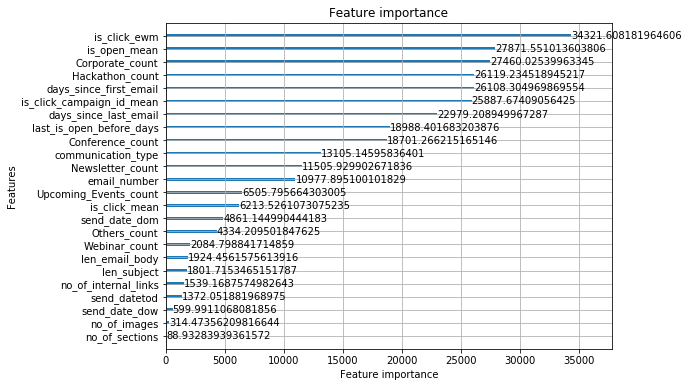

In [179]:
lightgbm.plot_importance(lgb, importance_type='gain')

In [151]:
# com_sample_ratio = ((df_f_t.communication_type.value_counts()/df_f_t.shape[0])/0.3904).to_dict()

# train_hack_c = df_f.communication_type.value_counts()[1]

# train_hack_c

# com_sample_ratio

# df_f_n = pd.DataFrame()
# for comm in df_f_t.communication_type.unique():
#     try:
#         df_curr = df_f.loc[df_f['communication_type']==comm].sample(int(train_hack_c))
#     except ValueError:
#         df_curr = df_f.loc[df_f['communication_type']==comm].sample(int(train_hack_c), replace=True)
#     df_f_n = pd.concat([df_f_n, df_curr])

# df_f_n.communication_type.value_counts()

# df_f_n.reset_index(drop=True,inplace=True)

In [178]:
# training on full dataset
lgb.fit(df_f[predictors], df_f['is_click'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.04, max_depth=4, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=700,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=3, reg_lambda=10, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [266]:
# preds_df = pd.DataFrame()
for i in range(1, 18):
    #curr best
    lgb = lightgbm.LGBMClassifier(n_estimators=700, learning_rate=0.04, max_depth=4, reg_lambda=10, reg_alpha=3, seed=i)
    # training on full dataset
    lgb.fit(df_f[predictors], df_f['is_click'])
    preds_df['pred_{}'.format(i)] = lgb.predict_proba(df_f_t[predictors])[:,1]
    print i, 'model trained'

12 model trained
13 model trained
14 model trained
15 model trained
16 model trained
17 model trained


In [186]:
df_f_t['is_click_campaign_id_mean'] = 0

In [181]:
preds_t = lgb.predict_proba(df_f_t[predictors])[:,1]

In [190]:
preds_t

array([0.00553573, 0.01449059, 0.00240888, ..., 0.00882201, 0.00994609,
       0.0181607 ])

In [267]:
preds_df.head()

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17
0,0.002851,0.003158,0.002953,0.003100,0.002700,0.002586,0.003125,0.002991,0.003046,0.003250,0.003090,0.003149,0.002690,0.002516,0.002553,0.002854,0.002855
1,0.002192,0.002115,0.002493,0.001982,0.002217,0.002229,0.002569,0.002028,0.002459,0.002312,0.001856,0.002003,0.002123,0.002108,0.002202,0.001942,0.002289
2,0.002570,0.002624,0.002716,0.002336,0.002297,0.002335,0.002705,0.002249,0.002497,0.002378,0.002280,0.002291,0.002206,0.002348,0.002437,0.002302,0.002713
3,0.002745,0.002488,0.002867,0.002221,0.002736,0.002780,0.002883,0.002378,0.002684,0.002614,0.002153,0.002150,0.002243,0.002653,0.002657,0.002361,0.002874
4,0.002279,0.002258,0.002313,0.002118,0.002343,0.002250,0.002587,0.002292,0.002352,0.002558,0.002064,0.002209,0.002011,0.002062,0.002234,0.002247,0.002493


In [268]:
sub = pd.DataFrame({'id':df_f_t['id'], 'is_click':preds_df.mean(1)})

In [269]:
sub.to_csv('/Users/aakashkerawat/NotebookProjects/AV_click/sub50_0.654_seed_en_17.csv', index=False)

### Experiement

In [159]:
# # df_all_user = df_all.loc[df_all.user_id==df_all.user_id.unique()[1]]

# use_cols = ['id', 'user_id', 'send_date', 'communication_type', 'Conference_count_new' ,'Corporate_count_new' ,'Hackathon_count_new', 'Newsletter_count_new', 'Others_count_new', 'Upcoming Events_count_new', 'Webinar_count_new']

# df_t.loc[df_t.user_id==6][use_cols]

# df_all_user[use_cols]

# df_all.drop(['Conference_count_new' ,'Corporate_count_new' ,'Hackathon_count_new', 'Newsletter_count_new', 'Others_count_new', 'Upcoming Events_count_new', 'Webinar_count_new'], 1, inplace=True)

# def get_cummulative_comm_count(df_temp):
#     return pd.get_dummies(df_temp['communication_type']).cumsum()

# df_all = pd.concat([df, df_t])

# df_all = df_all.sort_values(['user_id', 'send_date']).reset_index(drop=True)

# comm_types = df_all.groupby('user_id').progress_apply(get_cummulative_comm_count)

# comm_types.columns = comm_types.columns+'_count_new'

# comm_types.fillna(0, inplace=True)

# comm_types.replace(0, np.nan, inplace=True)

# df_all = pd.concat([df_all, comm_types] ,1)

# df_all['Conference_count_new'].head()

# df = df_all.loc[df_all['id'].isin(df['id'].unique())].reset_index(drop=True)

# df_t = df_all.loc[df_all['id'].isin(df_t['id'].unique())].reset_index(drop=True)

# path = '/Users/aakashkerawat/NotebookProjects/AV_click/'

# sub1 = pd.read_csv(path+'sub37_best_model_catboost.csv')

# sub2 = pd.read_csv(path+'sub_33_last_open_before_days_added.csv')

# sub2.shape

# sub_m = pd.merge(sub1, sub2, 'inner', ['id'])

# from scipy.stats import hmean

# sub_m.max()

# preds_n = sub_m['is_click_x']*0.2+sub_m['is_click_y']*0.8

# sub_n = pd.DataFrame({'id':sub_m['id'], 'is_click':hmean(sub_m[['is_click_x', 'is_click_y']], 1)})

# sub_n.to_csv(path+'sub_cat_and_light_2.csv', index=False)

# ### experiment/

# df_u = df.loc[df.user_id==df.user_id.unique()[1]].reset_index(drop=True)

# df_u_all = pd.concat([df.loc[df.user_id==12].reset_index(drop=True), df_t.loc[df_t.user_id==12]])

# df_u_all.is_click.value_counts()

# df_u_all = df_u_all.sort_values('send_date').reset_index(drop=True)

# df_u_all['last_click_date'] = df_u_all.loc[df_u_all.is_click.fillna(0).astype(bool), 'send_date']

# df_u_all[['id', 'user_id', 'is_click', 'send_date', 'last_click_date', 'last_click_before_days']]



In [174]:
path = '/Users/aakashkerawat/NotebookProjects/AV_click/'

sub1 = pd.read_csv(path+'sub41_comm_type_ratio.csv')

sub2 = pd.read_csv(path+'sub40best_model_clean_code_check.csv')

# sub2.shape

sub_m = pd.merge(sub1, sub2, 'inner', ['id'])

from scipy.stats import hmean

print sub_m.max()

# preds_n = sub_m['is_click_x']*0.2+sub_m['is_click_y']*0.8

sub_n = pd.DataFrame({'id':sub_m['id'], 'is_click':sub_m[['is_click_x', 'is_click_y']].mean(1)})

sub_n.to_csv(path+'sub_42_4041_mean.csv', index=False)

id            80_99976
is_click_x    0.794254
is_click_y    0.360991
dtype: object
